In [ ]:
!pip install pydantic langchain langgraph langchain-core langchain-community langchain-groq arxiv wikipedia

In [ ]:
GROQ_API_KEY='I used my api key here'

In [ ]:
#tools
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper

In [ ]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv, description="Query arxiv papers")
print(arxiv.name)

arxiv


In [ ]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [ ]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki, description="Query wikipedia")
print(wiki.name)

wikipedia


In [ ]:
#Initialize the LLM Model
from langchain_groq import ChatGroq

llm = ChatGroq(model='qwen/qwen3-32b', api_key=GROQ_API_KEY)

In [ ]:
llm.invoke("What is Agetic AI?")

AIMessage(content='<think>\nOkay, the user is asking what Agetic AI is. First, I need to confirm if this is a specific product or a concept. I remember that Alibaba Cloud has some AI products like Qwen, but "Agetic AI" isn\'t a term I\'m familiar with. Maybe it\'s a typo or a product from another company.\n\nLet me check if there\'s any official information from Alibaba Cloud about Agetic AI. A quick search shows no results. Perhaps the user meant Qwen, which is Alibaba\'s large language model. Alternatively, maybe they\'re referring to a different AI tool or service. I should also consider if it\'s a term from a different industry or context.\n\nSince there\'s no information available, I should inform the user that I can\'t find details about Agetic AI and suggest possible alternatives like Qwen or other AI assistants. It\'s important to be clear and helpful, offering to provide information on similar AI products if that\'s what they\'re looking for.\n</think>\n\nAs of my knowledge cu

In [ ]:
tools = [arxiv,wiki]

In [ ]:
llm_with_tools = llm.bind_tools(tools=tools)
llm_with_tools.invoke("What is Agetic AI?")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking, "What is Agetic AI?" I need to figure out the best way to answer this. Let me start by checking if Agetic AI is a known entity. I might not have heard of it before, so I should use the provided tools to look it up.\n\nFirst, I\'ll try using the Wikipedia function. If I search "Agetic AI" on Wikipedia, maybe there\'s an article about it. If there\'s no Wikipedia entry, then I can use the Arxiv function to check if there are any academic papers related to Agetic AI. \n\nWait, the user might be referring to a specific company, project, or concept. Since I don\'t have prior information, querying Wikipedia first makes sense. If that doesn\'t yield results, moving to Arxiv could help find any research papers. Let me start with Wikipedia.\n', 'tool_calls': [{'id': '3rphmz6pe', 'function': {'arguments': '{"query":"Agetic AI"}', 'name': 'wikipedia'}, 'type': 'function'}]}, response_metadata={'token_usage': 

# **Workflow**

In [ ]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage #Human message or AI message
from langchain_core.callbacks import CallbackManager
from typing import Annotated #labelling
from langgraph.graph.message import add_messages #Reducers in Langgraph

In [ ]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [ ]:
from IPython.display import display, Image
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

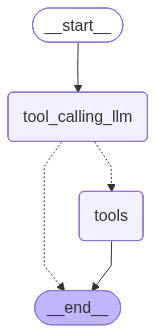

In [ ]:
#Node definition
def tool_calling_llm(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

#Build Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

#Edges
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)
builder.add_edge("tools",END)
graph=builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
messages = graph.invoke ({"messages":"Attention Is All You Need"})
for m in messages['messages']:
  m.pretty_print()

================================ Human Message =================================

Attention Is All You Need
================================== Ai Message ==================================

The phrase "Attention Is All You Need" refers to the groundbreaking 2017 research paper introducing the **Transformer** model, which revolutionized natural language processing. The paper demonstrated that self-attention mechanisms could replace recurrent layers entirely, enabling parallelizable sequence modeling.

Would you like me to:
1. Provide a summary of the key contributions?
2. Retrieve the original arXiv paper ([arXiv:1706.03762](https://arxiv.org/abs/1706.03762))?
3. Explain how the Transformer architecture works?
4. Discuss its impact on modern NLP?

Let me know how I can best assist!
